In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print('X:', X.shape, 'y:', y.shape)

X: (70000, 784) y: (70000,)


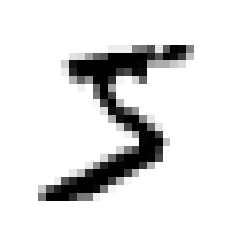

In [4]:
some_digit= X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
# MK algorithms expect numbers
y = y.astype(np.uint8)
y[0]

5

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifiers (or 5 detector)

## Train

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

## Cross-validation

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# keep in mind : 10% of images are 5s

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


In [13]:
# precision score = TP / (TP + FP)
precision_score(y_train_5, y_train_pred)  # == 3530 / (3530 + 687)

0.8370879772350012

In [14]:
# recall score = TP / (TP + FN)
recall_score(y_train_5, y_train_pred)  # == 3530 / (3530 + 1891)
# low recall : rejects many goods

0.6511713705958311

In [15]:
# harmonic mean of precision and recall score
f1_score(y_train_5, y_train_pred)  # 2 / (1/precision + 1/recall)

0.7325171197343846

### Precision/recall trade-off

In [16]:
# SGDClassifier uses a threshold equal to 0
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]
[False]


In [17]:
y_scores = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
    method='decision_function'
)

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train_5,
    y_scores
)

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.legend(loc="center left", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)

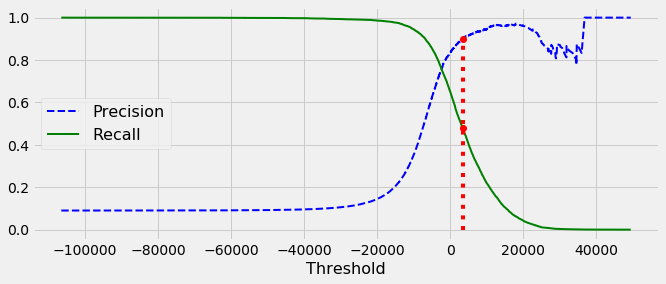

Precision: 0.90 recall: 0.48 threshold: 3370


In [20]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 4))

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

precision_wanted = .9  # consequence on recall

if precision_wanted:
    recall_precision = recalls[np.argmax(precisions >= precision_wanted)]
    threshold_precision = thresholds[np.argmax(precisions >= precision_wanted)]

    plt.plot([threshold_precision, threshold_precision], [0., precision_wanted], "r:")
    plt.plot([threshold_precision], [precision_wanted], "ro")
    plt.plot([threshold_precision], [recall_precision], "ro")

    plt.show()

    print(
        f"Precision: {precision_wanted:.2f}",
        f"recall: {recall_precision:.2f}",
        f"threshold: {threshold_precision:.0f}"
    )

## ROC curve

In [21]:
from sklearn.metrics import roc_curve
# fpr : false positive rate
# tpr : true positive rate
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel('False positive rate (fall-out)', fontsize=10)
    plt.ylabel('True positive rate (recall)', fontsize=10)

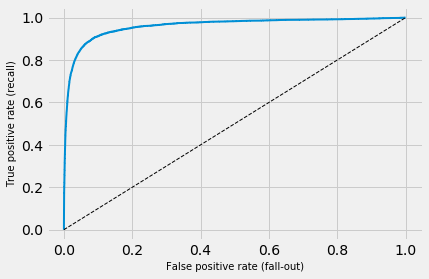

In [23]:

plot_roc_curve(fpr, tpr)
plt.show()

Area under the curve (AUC) is one way to compare classifiers. Perfect classifier 1, random classifier .5.

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Prefer the PR (precision/recall) curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. 

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=30)
y_probas_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=3,
    method='predict_proba'
)

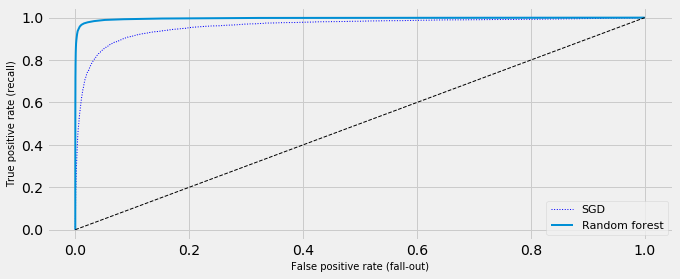

In [26]:
y_scores_forest = y_probas_forest[:, 1]  # keep only positive class proba

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, "b:", linewidth=1, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=11)
plt.show()

In [27]:
roc_auc_score(y_train_5, y_scores_forest)

0.9966794932276952

## Multi classification

In [28]:
#from sklearn.svm import SVC

#svm_clf = SVC()  # gamma='auto'
#svm_clf.fit(X_train, y_train)

#svm_clf.predict([some_digit])

In [31]:
rdf_clf = RandomForestClassifier(random_state=42, n_estimators=30)
rdf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
some_digit_scores = rdf_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
rdf_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [38]:
rdf_clf.classes_[5]

5

In [40]:
cross_val_score(rdf_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.95940812, 0.95829791, 0.96184428])

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [41]:
cross_val_score(rdf_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.95935813, 0.95829791, 0.96184428])

In [42]:
y_train_pred = cross_val_predict(rdf_clf, X_train_scaled, y_train, cv=3)

In [43]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5835,    2,    5,    4,    6,    9,   23,    1,   35,    3],
       [   0, 6624,   31,   21,   13,    8,    8,   11,   18,    8],
       [  38,   16, 5723,   27,   31,    3,   18,   48,   45,    9],
       [  13,    8,  106, 5753,    5,   83,    5,   47,   77,   34],
       [  12,   10,   15,    3, 5627,    4,   31,   16,   14,  110],
       [  22,   15,   11,   98,   12, 5157,   40,    7,   36,   23],
       [  32,   11,    6,    2,   13,   47, 5781,    0,   25,    1],
       [  10,   26,   69,    8,   42,    3,    1, 6017,   11,   78],
       [  16,   39,   49,   76,   35,   56,   31,   10, 5481,   58],
       [  23,   11,   21,   75,   96,   21,    5,   62,   43, 5592]],
      dtype=int64)

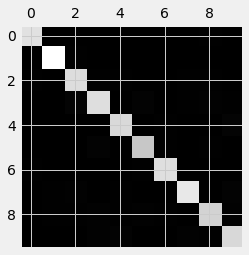

In [44]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Divide each value in the confusion matrix by the number of images in the corresponding class to compare error rates instead of absolute numbers of errors.

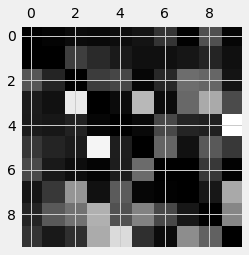

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)  # keep only errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel classification

In [49]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(
    knn_clf,
    X_train,
    y_multilabel,
    cv=3
)

f1_score(y_multilabel, y_train_knn_pred, average='macro')